# Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-01-11 06:08:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-11 06:08:27 (87.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-01-11 06:08:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  22.9MB/s    in 70s     

2025-01-11 06:09:51 (22.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
unzip_data("101_food_classes_10_percent.zip")

In [5]:
!rm "101_food_classes_10_percent.zip"

In [6]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [7]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caprese_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in

In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             label_mode="categorical",
                                                             image_size=IMG_SIZE,
                                                             shuffle=False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [9]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [10]:
# Create data augmentation layer to incorporate it right into the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
    # layers.Rescaling(1./255) # Keep for models like ResNet50V2 but EfficientNet's having resclaing built-in
], name="data_augmentation")

In [11]:
# Setup the base model amd freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay froze
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [12]:
# Get a summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool_layer                │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 61s 194ms/step - accuracy: 0.1276 - loss: 4.0687 - val_accuracy: 0.4049 - val_loss: 2.7557
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.4104 - loss: 2.5840 - val_accuracy: 0.4407 - val_loss: 2.2531
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 83s 182ms/step - accuracy: 0.4889 - loss: 2.1834 - val_accuracy: 0.5310 - val_loss: 1.9087
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - accuracy: 0.5371 - loss: 1.9311 - val_accuracy: 0.5458 - val_loss: 1.8463
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.5686 - loss: 1.7981 - val_accuracy: 0.5938 - val_loss: 1.6207


In [14]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.5051 - loss: 1.9309


[1.8164693117141724, 0.5326336622238159]

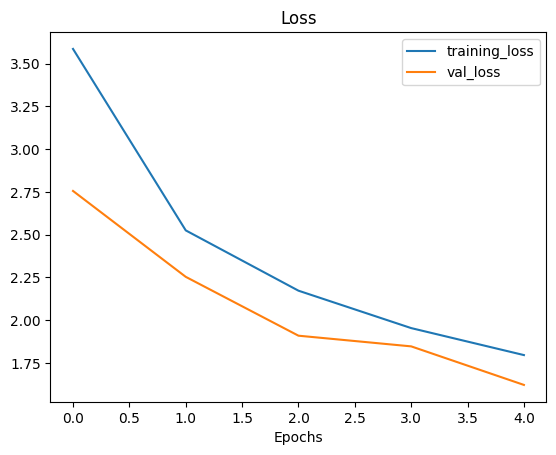

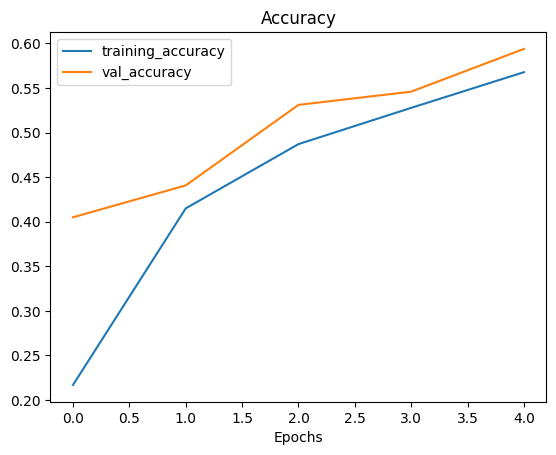

In [15]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [17]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [18]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [19]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [20]:
# Fine-tune for 5 more epochs
FINE_TUNE_EPOCHS = 10

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=FINE_TUNE_EPOCHS,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 55s 185ms/step - accuracy: 0.5612 - loss: 1.7822 - val_accuracy: 0.4966 - val_loss: 1.9869
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 163ms/step - accuracy: 0.6175 - loss: 1.5658 - val_accuracy: 0.5270 - val_loss: 1.7820
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 166ms/step - accuracy: 0.6370 - loss: 1.4717 - val_accuracy: 0.5953 - val_loss: 1.5992
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 165ms/step - accuracy: 0.6552 - loss: 1.4097 - val_accuracy: 0.5723 - val_loss: 1.6408
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.6747 - loss: 1.3405 - val_accuracy: 0.6234 - val_loss: 1.4617
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 160ms/step - accuracy: 0.6870 - loss: 1.2794 - val_accuracy: 0.6035 - val_loss: 1.4490


In [21]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.5487 - loss: 1.7298


[1.61050546169281, 0.5754851698875427]

In [22]:
import matplotlib.pyplot as plt

# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow History objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics with new_history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]


    # Make plot for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning", color="r") # Plotting the line where fine tuning started
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")


    # Make plot for loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Val Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning", color="r") # Plotting the line where fine tuning started
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

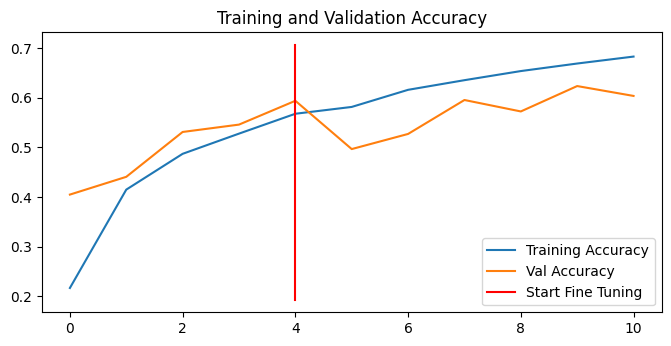

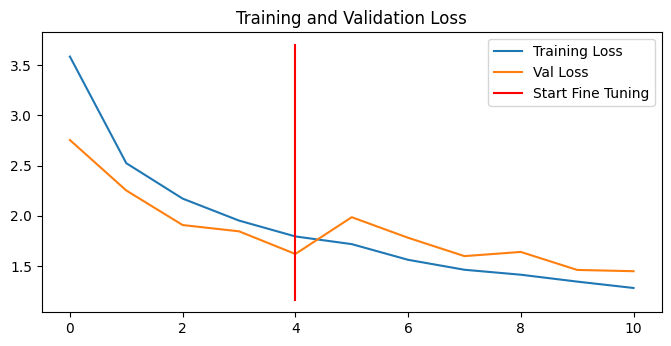

In [23]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent, new_history=history_all_classes_10_percent_fine_tune, initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [24]:
!mkdir "models"

In [25]:
model.save("/content/models/101_food_classes_10_percent_saved_big_dog_model.keras")

In [26]:
# Load and evaluate save model
loaded_model = tf.keras.models.load_model("/content/models/101_food_classes_10_percent_saved_big_dog_model.keras")

In [27]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 78ms/step - accuracy: 0.5226 - loss: 1.8511


[1.688650369644165, 0.5546534657478333]

In [28]:
# The results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.61050546169281, 0.5754851698875427]

## Making predictions with our trained model

In [29]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # Set verbosity to see how long is left

790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 70ms/step


In [30]:
len(test_data)

790

In [31]:
# How many predictions are there?
len(preds_probs)

25250

In [32]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [33]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[3.06276113e-01, 1.18063111e-03, 2.63615966e-01, ...,
        1.41483746e-04, 2.75055016e-03, 2.58383639e-02],
       [8.09147298e-01, 4.34861568e-06, 2.91316048e-03, ...,
        5.02219331e-03, 9.43642135e-06, 3.50318151e-05],
       [1.98545575e-01, 5.89305023e-03, 6.92153117e-03, ...,
        2.59376853e-03, 2.66458257e-04, 3.53222783e-03],
       ...,
       [2.25689799e-01, 2.26721586e-05, 1.41645002e-03, ...,
        1.24079742e-01, 4.01355006e-04, 5.90379757e-04],
       [1.03071325e-01, 2.29297555e-03, 1.12970658e-01, ...,
        3.25338566e-03, 3.42105865e-04, 7.54385605e-04],
       [3.87824625e-01, 3.42626299e-05, 1.20664679e-03, ...,
        1.23987496e-02, 3.54797994e-05, 3.76748806e-03]], dtype=float32)

In [34]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([3.0627611e-01, 1.1806311e-03, 2.6361597e-01, 5.5990171e-07,
        1.2129758e-05, 8.3026471e-06, 1.1546487e-03, 1.3668617e-04,
        2.9472403e-02, 6.1941729e-04, 5.5731075e-06, 4.2066640e-05,
        3.2618970e-03, 4.5834959e-06, 1.1607171e-02, 1.9422716e-03,
        4.5772496e-04, 1.7477034e-03, 3.3274118e-04, 2.4191006e-05,
        2.3282930e-04, 2.3117244e-04, 1.9677900e-04, 7.8300713e-04,
        3.3897095e-04, 6.8067486e-04, 4.8816775e-04, 4.1153347e-05,
        5.3379253e-02, 1.0279241e-03, 1.9903098e-05, 2.3926473e-03,
        1.8240464e-03, 1.0514875e-05, 1.1462917e-02, 5.5450597e-05,
        5.6219171e-04, 1.7814712e-03, 1.6394833e-02, 5.1693431e-05,
        6.4949429e-04, 2.6033071e-04, 1.2761150e-03, 1.3578752e-05,
        2.7550248e-05, 8.9293031e-04, 6.1478838e-04, 1.5636593e-04,
        2.8723833e-05, 3.1468295e-03, 2.1837575e-03, 2.8765637e-05,
        1.2727885e-01, 2.5636172e-03, 2.2054308e-05, 1.8474866e-02,
        4.5279567e-03, 1.1786742e-03, 7.7112806e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [35]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [3.0627611e-01 1.1806311e-03 2.6361597e-01 5.5990171e-07 1.2129758e-05
 8.3026471e-06 1.1546487e-03 1.3668617e-04 2.9472403e-02 6.1941729e-04
 5.5731075e-06 4.2066640e-05 3.2618970e-03 4.5834959e-06 1.1607171e-02
 1.9422716e-03 4.5772496e-04 1.7477034e-03 3.3274118e-04 2.4191006e-05
 2.3282930e-04 2.3117244e-04 1.9677900e-04 7.8300713e-04 3.3897095e-04
 6.8067486e-04 4.8816775e-04 4.1153347e-05 5.3379253e-02 1.0279241e-03
 1.9903098e-05 2.3926473e-03 1.8240464e-03 1.0514875e-05 1.1462917e-02
 5.5450597e-05 5.6219171e-04 1.7814712e-03 1.6394833e-02 5.1693431e-05
 6.4949429e-04 2.6033071e-04 1.2761150e-03 1.3578752e-05 2.7550248e-05
 8.9293031e-04 6.1478838e-04 1.5636593e-04 2.8723833e-05 3.1468295e-03
 2.1837575e-03 2.8765637e-05 1.2727885e-01 2.5636172e-03 2.2054308e-05
 1.8474866e-02 4.5279567e-03 1.1786742e-03 7.7112806e-03 1.8805491e-05
 6.9340354e-07 4.1965907e-04 1.3437052e-03 9.

In [36]:
test_data.class_names[0]

'apple_pie'

In [37]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29, 46,  9,  0])

In [38]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:10]

In [ ]:
# How many y_labels are there?
len(y_labels)

## Evaluating our model's predictions

One way to check that our model's predictions array (pred_classes) is in the same order as our test labels array (y_labels) is to find the accuracy score.

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

### Let's get visual: making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report


Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classification_report, let's try it out.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

In [ ]:
# Trun f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
# What does our dataframe look like?
f1_scores[:10]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

### Visualizing predictions on test images

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose random image(s) from random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list
  # print(pred_prob)
  # print(pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  # print(img)
  plt.imshow(img/225.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "blue"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:

1. Get all of the image file paths in the test dataset using list_files() method
Create a pandas DataFrame of the image filepaths, ground truth labels,

2. predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.

3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).

4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).

5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [54]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [55]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.306276,apple_pie,apple_pie
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.809147,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.198546,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.160238,apple_pie,bread_pudding
4,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.406752,apple_pie,bread_pudding
...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.928380,waffles,waffles
25246,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.968641,waffles,waffles
25247,b'/content/101_food_classes_10_percent/test/wa...,100,56,0.545107,waffles,huevos_rancheros
25248,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.386542,waffles,waffles


In [56]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.306276,apple_pie,apple_pie,True
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.809147,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.198546,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.160238,apple_pie,bread_pudding,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.406752,apple_pie,bread_pudding,False


In [57]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
23631,b'/content/101_food_classes_10_percent/test/st...,94,83,0.998736,strawberry_shortcake,red_velvet_cake,False
10847,b'/content/101_food_classes_10_percent/test/fr...,43,68,0.996803,fried_calamari,onion_rings,False
19521,b'/content/101_food_classes_10_percent/test/po...,78,40,0.994892,poutine,french_fries,False
14062,b'/content/101_food_classes_10_percent/test/hu...,56,28,0.992583,huevos_rancheros,croque_madame,False
18325,b'/content/101_food_classes_10_percent/test/pa...,73,98,0.991613,panna_cotta,tiramisu,False
22,b'/content/101_food_classes_10_percent/test/ap...,0,100,0.991234,apple_pie,waffles,False
9073,b'/content/101_food_classes_10_percent/test/fa...,36,26,0.988591,falafel,crab_cakes,False
22606,b'/content/101_food_classes_10_percent/test/sp...,90,1,0.987185,spaghetti_bolognese,baby_back_ribs,False
8767,b'/content/101_food_classes_10_percent/test/es...,35,65,0.987100,escargots,mussels,False
23797,b'/content/101_food_classes_10_percent/test/su...,95,86,0.986749,sushi,sashimi,False


In [58]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
# images_to_view = 9
# start_index = 0
# plt.figure(figsize=(15, 10))
# for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
#   plt.subplot(3, 3, i+1)
#   img = load_and_prep_image(row[1], scale=False)
#   _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
#   plt.imshow(img/255.)
#   plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
#   plt.axis(False)

## Test out the big dog model on our own custom images

In [59]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2025-01-11 06:30:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  7.42MB/s    in 1.7s    

2025-01-11 06:30:33 (7.42 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [60]:
!rm custom_food_images.zip

In [61]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


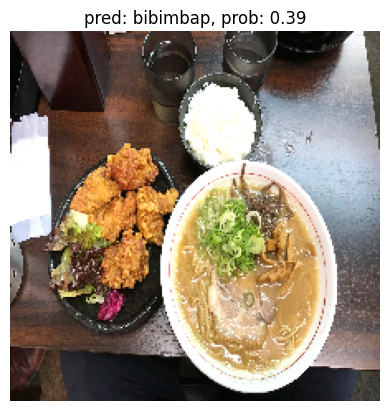

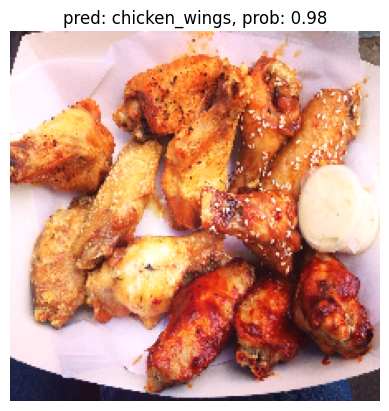

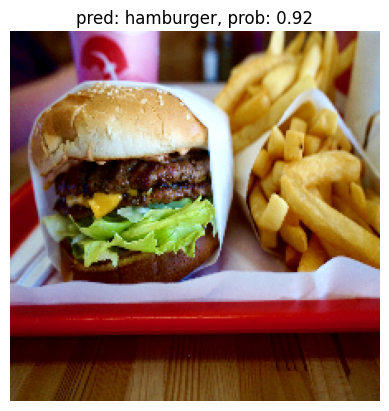

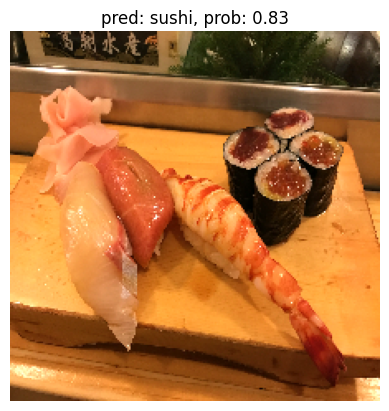

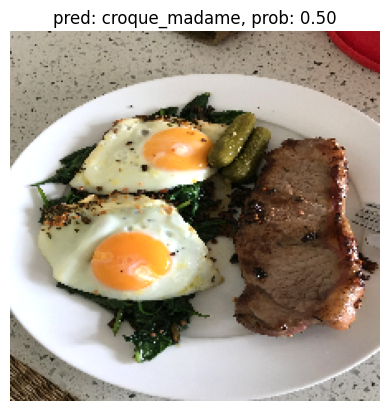

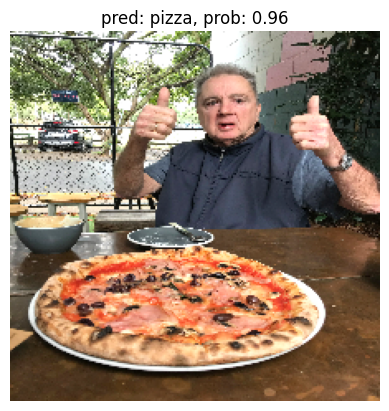

In [62]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highet prediction probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/225.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)